In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501.xlsx


In [2]:
df = pd.read_excel('202501.xlsx')

In [3]:
# 시간 컬럼 datetime 변환 (Pump-Begin 기준)
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])

In [4]:
# 금속 컬럼 추출
metal_columns = [col for col in df.columns if '(ng/m3)' in col]

In [5]:
# 음수값 전처리
df[metal_columns] = df[metal_columns].apply(lambda col: col.where(col >= 0))
df = df.dropna(subset=metal_columns, how='all')

In [6]:
# 날짜 컬럼 생성
df['Date'] = df['Pump-Begin'].dt.date

# 날짜 분할 (11일 단위)
unique_dates = sorted(df['Date'].unique())
chunks = [unique_dates[i:i+11] for i in range(0, len(unique_dates), 11)]

In [7]:
# 금속별 최대값 설정
metal_max_dict = {metal: df[metal].max() * 1.1 for metal in metal_columns}

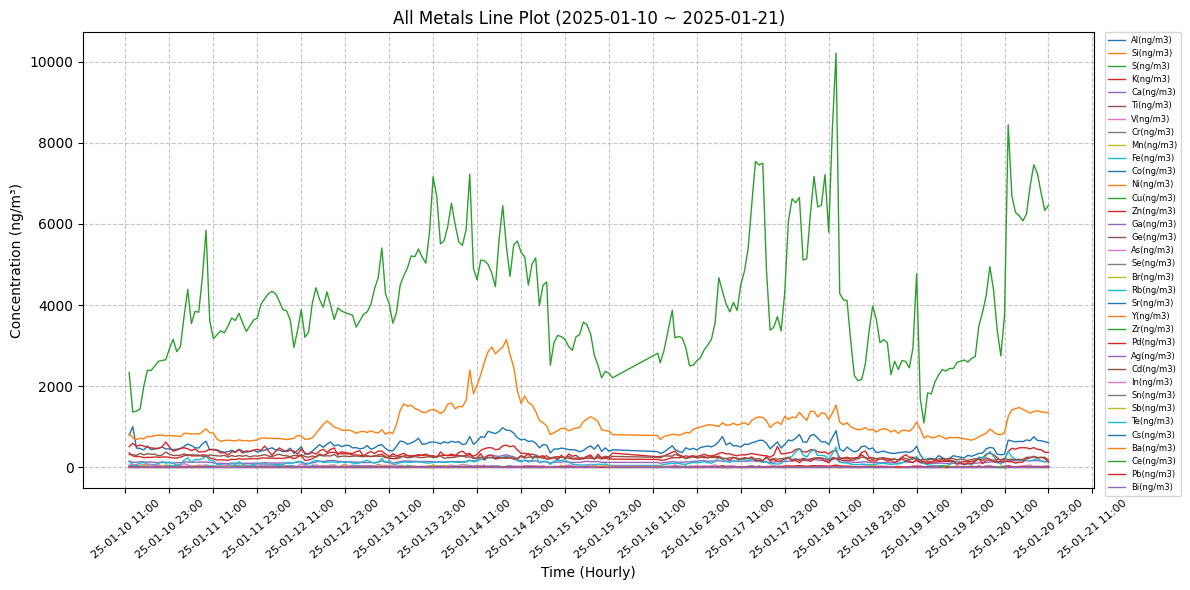

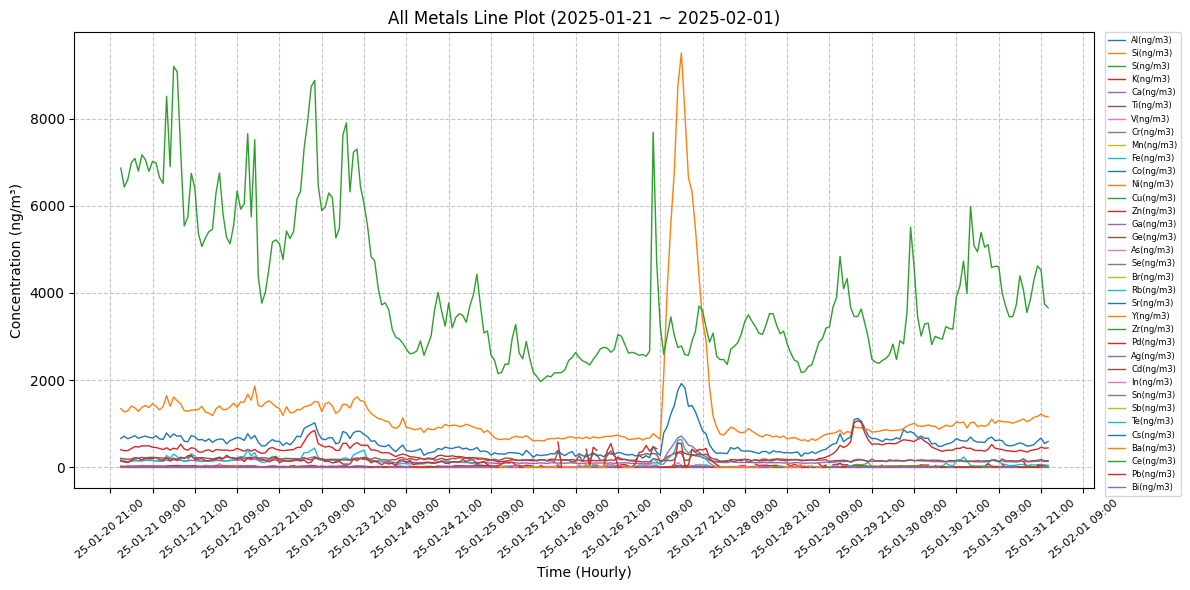

In [8]:
from types import FunctionType
# 전체 금속 선 그래프 그리기
for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date = pd.to_datetime(max(date_group)) + pd.Timedelta(days=1)

    temp_df = df[(df['Pump-Begin'] >= start_date) &
                 (df['Pump-Begin'] < end_date)].copy()
    temp_df = temp_df.sort_values('Pump-Begin')

    plt.figure(figsize=(12, 6))

    # 모든 금속 선 그리기
    for metal in metal_columns:
        plt.plot(temp_df['Pump-Begin'], temp_df[metal], label=metal, linewidth=1)

    # x축 설정 (12시간 단위로 표시, 데이터는 1시간 단위)
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
    plt.xticks(rotation=40, fontsize=8)

    # 격자 설정
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # 제목과 라벨
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Concentration (ng/m³)')
    plt.title(f'All Metals Line Plot ({start_date.date()} ~ {end_date.date()})')

    # 범례 설정
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1),
               fontsize=6, ncol=1, borderaxespad=0)

    # 그래프 출력
    plt.tight_layout()
    plt.show()